# **TP MACHINE LEARNING 3 . 2025-2026 . BOOSTING, BAGGING, STACKING**

Version du 12/12/2025

L'objectif de ce TP est de mettre en application les algorithmes relatifs aux méthodes d'agrégation et de convexité (en classification et régression), et les comparer aux autres méthodes d'apprentissage supervisé ($k$-ppv, arbres de décision, régression logistique, machines à vecteurs de support et réseaux de neurones).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor,AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import train_test_split

Quelques fonctions de scikit-learn que nous allons utiliser et dont il faut lire la documentation en ligne :

- DecisionTreeRegressor.
- DecisionTreeClassifier.
- AdaBoostRegressor.
- AdaBoostClassifier.
- GradientBoostingRegressor.
- GradientBoostingClassifier.
- XGBClassifier
- CatBoostClassifier
- LGBMClassifier
- RandomForestClassifier.
- StackingClassifier.
- BaggingRegressor.
- RandomForestRegressor.




# **Partie 1 : régression avec Adaboost.**

1°. 2°. 3°. Mise en bouche : on génère des données se trouvant sur une sinusoïde perturbée par un bruit aléatoire. On compare alors deux régresseurs : le premier à partir d'un arbe de décision et le second utilisant Adaboost.
On visualise l'écart entre les données et les régresseurs.

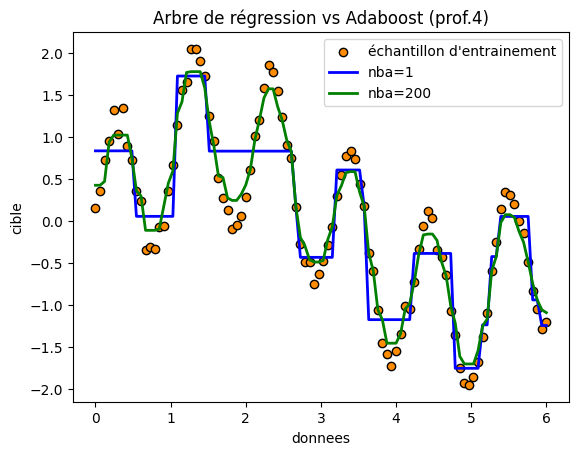

In [2]:
import sklearn.linear_model as lm
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])
modele1 = DecisionTreeRegressor(max_depth=4)
modele2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=200, random_state=rng)
#modele1 = AdaBoostRegressor(lm.LinearRegression(fit_intercept=True), n_estimators=200, random_state=rng)
modele1.fit(X, y)
modele2.fit(X, y)
y_1 = modele1.predict(X)
y_2 = modele2.predict(X)
plt.figure()
plt.scatter(X, y, edgecolor="black", color="darkorange", label="échantillon d'entrainement")
plt.plot(X, y_1, color="blue", label="nba=1", linewidth=2)
plt.plot(X, y_2, color="green", label="nba=200", linewidth=2)
plt.xlabel("donnees")
plt.ylabel("cible")
plt.title("Arbre de régression vs Adaboost (prof.4)")
plt.legend()
plt.show()

Utilisation de GridSearchCV pour déterminer les meilleurs choix de paramètres sur l'exemple précédent.

Meilleurs paramètres pour l'arbre :  {'max_depth': 3, 'min_samples_leaf': 2}
Meilleurs paramètres pour AdaBoost :  {'estimator__max_depth': 2, 'learning_rate': 0.05, 'n_estimators': 100}


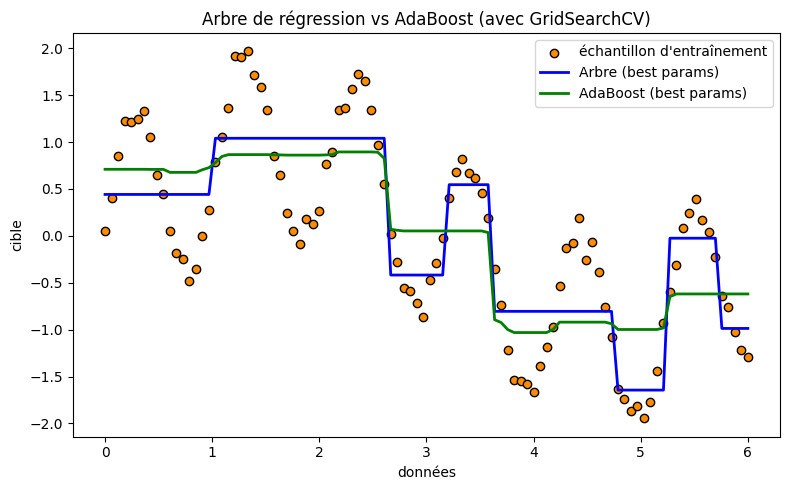

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

rng = np.random.RandomState(42)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])
param_grid_tree = {
    "max_depth": [3, 4, 5, None],
    #"min_samples_leaf": [2, 3, 5, 10]
    "min_samples_leaf": [2, 3]
}

# Arbre
tree_base = DecisionTreeRegressor(random_state=1)
grid_tree = GridSearchCV(
    estimator=tree_base,
    param_grid=param_grid_tree,
    cv=5,
    scoring=None,
    n_jobs=-1
)
grid_tree.fit(X, y)
best_tree = grid_tree.best_estimator_
print("Meilleurs paramètres pour l'arbre : ", grid_tree.best_params_)

# Boosting
base_estimator = DecisionTreeRegressor(random_state=1)
param_grid_boost = {
    #"n_estimators": [50, 100, 200, 400, 1000],
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "estimator__max_depth": [2,3,4,10]
}
boost = AdaBoostRegressor(
    estimator=base_estimator,
    random_state=1
)
grid_boost = GridSearchCV(
    estimator=boost,
    param_grid=param_grid_boost,
    cv=5,
    scoring=None,
    n_jobs=-1
)
grid_boost.fit(X, y)
best_boost = grid_boost.best_estimator_
print("Meilleurs paramètres pour AdaBoost : ", grid_boost.best_params_)

y_tree = best_tree.predict(X)
y_boost = best_boost.predict(X)
plt.figure(figsize=(8, 5))
plt.scatter(X, y, edgecolor="black", color="darkorange", label="échantillon d'entraînement")
plt.plot(X, y_tree, color="blue", label="Arbre (best params)", linewidth=2)
plt.plot(X, y_boost, color="green", label="AdaBoost (best params)", linewidth=2)
plt.xlabel("données")
plt.ylabel("cible")
plt.title("Arbre de régression vs AdaBoost (avec GridSearchCV)")
plt.legend()
plt.tight_layout()
plt.show()

# **Partie 2 : classification ; comparaison de Adaboost et Gradient Boosting.**

4°. 5°. 6°. Utilisation d'Adaboost et gradient boosting en classification, avec un exemple simple la fonction make_hastie_10_2.

Quelques précisions sur la fonction make_hastie:

- Pour chaque point, on génère un vecteur aléatoire $X=(X_1,X_2,…,X_{10})$ où chaque composante est tirée selon une loi normale standard : $X_j\sim\mathcal{N}(0,1)$. On calcule la norme euclidienne $||X||$ de ce vecteur.

- La classe est définie selon une règle quadratique $y=\text{sgn}(r^2-9.34)$. La valeur 9.34 est choisie pour obtenir un ratio équilibré entre les deux classes.

- Les données sont dispersées en dimension 10 et la séparation n'est pas linéaire (c'est une frontière sphérique dans $\mathbb{R}^{10}$). Les points proches de l'origine sont dans la classe $-1$ et les points plus éloignés dans la classe +1. La frontière entre classes est un hypersphère de rayon environ $\sqrt{9.34}\sim3$. Les deux classes ressemblent à une boule centrale (classe -1) et un anneau autour (classe +1).

- C'est le type de structure difficile pour un modèle linéaire, donc les méthodes non linéaires sont efficaces dessus, notamment Gradient Boosting, AdaBoost, Random Forest, SVM non linéaire.

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


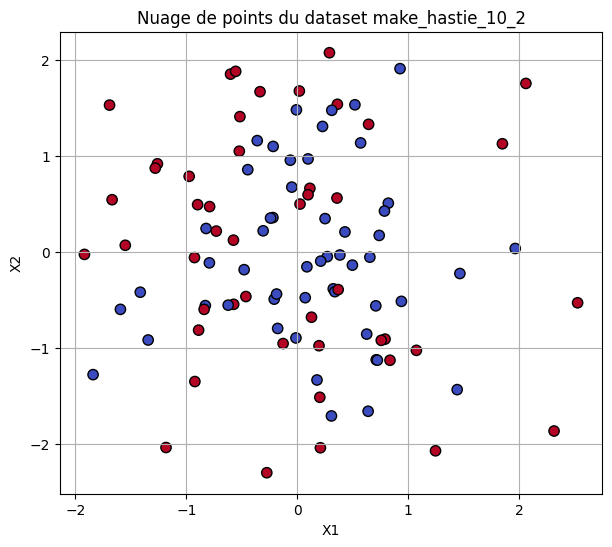

ACC Gradient Boost: 1.0000
ACC Adaboost: 1.0000


array([0.69869707, 0.30130293])

In [4]:
from sklearn.datasets import make_hastie_10_2
X, y = make_hastie_10_2(n_samples=100,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)
estim1 = GradientBoostingClassifier(n_estimators=200, max_depth=3)
estim2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),algorithm="SAMME",n_estimators=200, random_state=0)
estim1.fit(X, y)
estim2.fit(X, y)
plt.figure(figsize=(7, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=55, edgecolor="black")
plt.title("Nuage de points du dataset make_hastie_10_2")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()
pred1 = estim1.predict(X)
pred2 = estim1.predict(X)
acc1 = estim1.score(X_test, y_test)
acc2 = estim2.score(X_test, y_test)
print('ACC Gradient Boost: %.4f' % acc1)
print('ACC Adaboost: %.4f' % acc2)
estim1.predict_proba(X)[0]
estim1.predict_proba(X_test)[0]
estim2.predict_proba(X)[0]
estim2.predict_proba(X_test)[0]

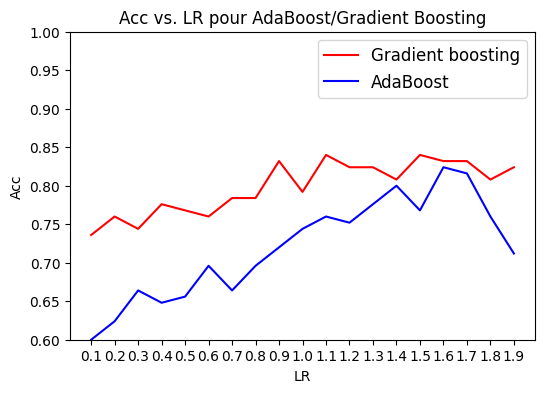

In [5]:
from sklearn.datasets import make_hastie_10_2
X, y = make_hastie_10_2(n_samples=500)
X_train, X_test, y_train, y_test = train_test_split(X, y)
# AdaBoost
learning_rate_range = np.arange(0.1, 2, 0.1)
testada = []
trainada = []
for lr in learning_rate_range:
    ada= AdaBoostClassifier(learning_rate=lr, n_estimators=100)
    ada.fit(X_train, y_train)
    trainada.append(ada.score(X_train, y_train))
    testada.append(ada.score(X_test, y_test))
# Gradient boosting
testgb = []
traingb = []
for lr in learning_rate_range:
    gb= GradientBoostingClassifier(learning_rate=lr, n_estimators=100)
    gb.fit(X_train, y_train)
    traingb.append(gb.score(X_train, y_train))
    testgb.append(gb.score(X_test, y_test))
# AdaBoost vs. Gradient Boosting
fig = plt.figure(figsize=(6, 4))
plt.plot(learning_rate_range, testgb, c='red', label='Gradient boosting')
plt.plot(learning_rate_range, testada, c='blue', label='AdaBoost')
plt.xlabel('LR')
plt.xticks(learning_rate_range)
plt.ylabel('Acc')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12})
plt.title('Acc vs. LR pour AdaBoost/Gradient Boosting', size=12)
plt.show()

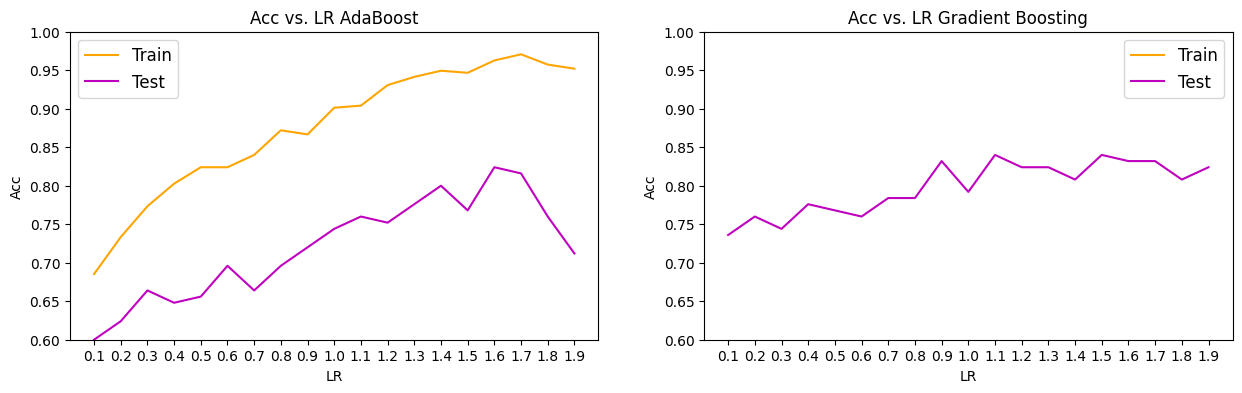

In [6]:
fig = plt.figure(figsize=(15, 4))
# AdaBoost
fig.add_subplot(121)
plt.plot(learning_rate_range, trainada, c='orange', label='Train')
plt.plot(learning_rate_range, testada, c='m', label='Test')
plt.xlabel('LR')
plt.xticks(learning_rate_range)
plt.ylabel('Acc')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12})
plt.title('Acc vs. LR AdaBoost', size=12)
# Gradient boosting
fig.add_subplot(122)
plt.plot(learning_rate_range, traingb, c='orange', label='Train')
plt.plot(learning_rate_range, testgb, c='m', label='Test')
plt.xlabel('LR')
plt.xticks(learning_rate_range)
plt.ylabel('Acc')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12})
plt.title('Acc vs. LR Gradient Boosting', size=12)
plt.show()

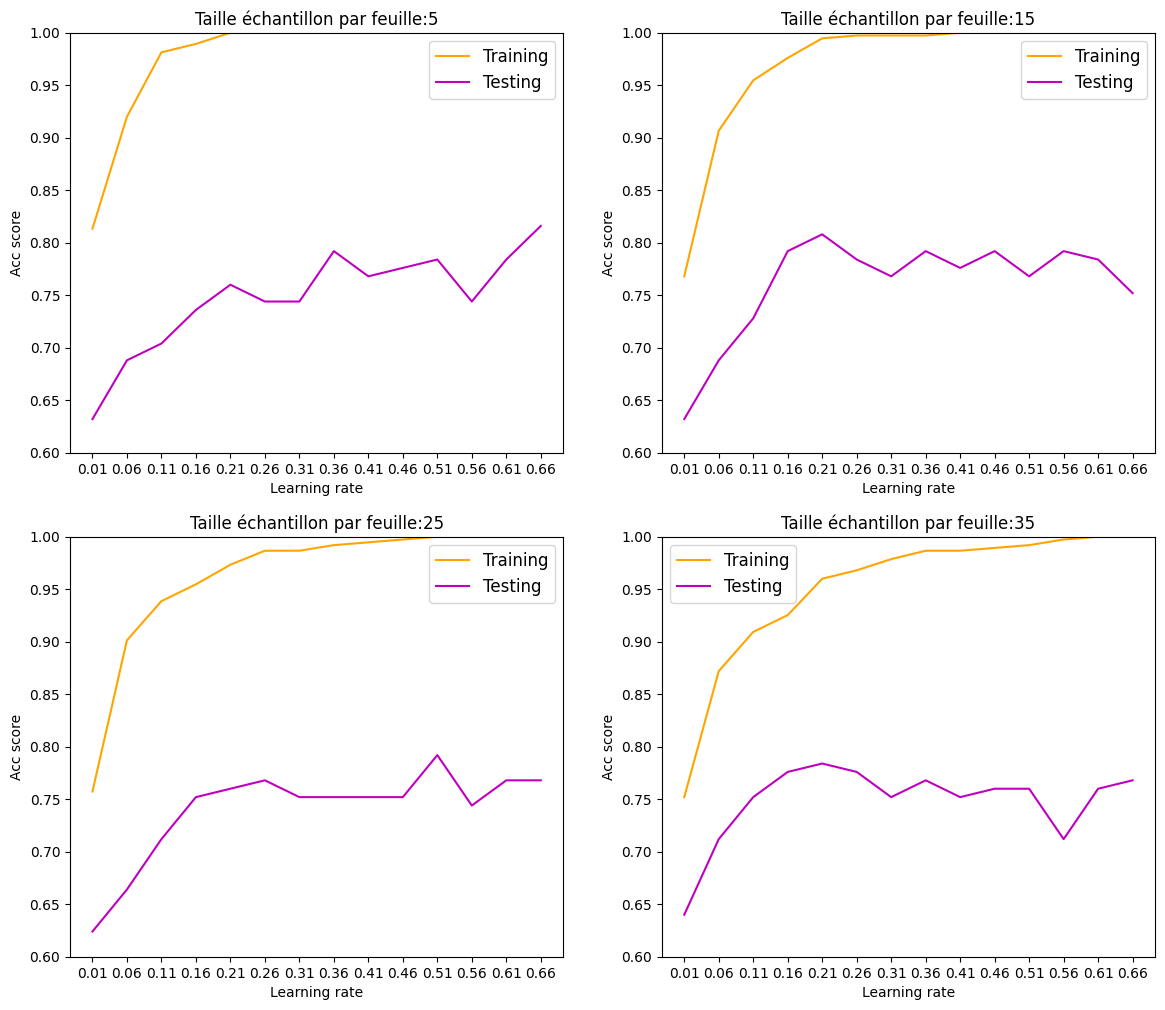

In [7]:
learning_rate_range = np.arange(0.01, 0.7, 0.05)
fig = plt.figure(figsize=(14, 12))
idx = 1
for leaf in range(5, 45, 10):
    train = []
    test = []
    for lr in learning_rate_range:
        gb= GradientBoostingClassifier(learning_rate=lr, n_estimators=50, min_samples_leaf=leaf)
        gb.fit(X_train, y_train)
        train.append(gb.score(X_train, y_train))
        test.append(gb.score(X_test, y_test))
    fig.add_subplot(2, 2, idx)
    idx += 1
    plt.plot(learning_rate_range, train, c='orange', label='Training')
    plt.plot(learning_rate_range, test, c='m', label='Testing')
    plt.xlabel('Learning rate')
    plt.xticks(learning_rate_range)
    plt.ylabel('Acc score')
    plt.ylim(0.6, 1)
    plt.legend(prop={'size': 12})
    title = "Taille échantillon par feuille:" + str(leaf)
    plt.title(title, size=12)
plt.show()

# **Partie 3 : Gradient Boosting en régression.**

7° à 11°. Utilisation de GBRT (Gradient Boosted Regression Tree) qui est une version de l'algorithme de Gradient Boosting sur des arbres de décisions et fait partie de la bibliothèque scikit-learn. On s'intéresse à un problème de régression et on part à nouveau sur une sinusoïde perturbée (échantillon de taille 100 pour l'entrainement et 100 pour le test).
Les hyperparamètres à surveiller : nombre d'arbres (n_estimators), profondeur de chaque arbre (max_depth), fonction de perte (loss) et learning rate (learning_rate).

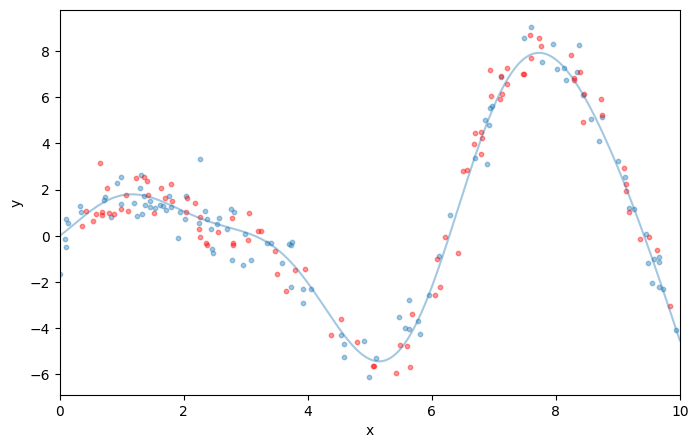

In [8]:
def ground_truth(x):
  return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
  np.random.seed(13)
  x = np.random.uniform(0, 10, size=n_samples)
  x.sort()
  y = ground_truth(x) + 0.75 * np.random.normal(size=n_samples)
  train_mask = np.random.randint(0, 2, size=n_samples).astype(bool)
  x_train, y_train = x[train_mask, np.newaxis], y[train_mask]
  x_test, y_test = x[~train_mask, np.newaxis], y[~train_mask]
  return x_train, x_test, y_train, y_test
X_train, X_test, y_train, y_test = gen_data(200)
x_plot = np.linspace(0, 10, 500)

def plot_data(figsize=(8, 5)):
  fig = plt.figure(figsize=figsize)
  gt = plt.plot(x_plot, ground_truth(x_plot), alpha=0.4, label='Données réelles')
  plt.scatter(X_train, y_train, s=10, alpha=0.4)
  plt.scatter(X_test, y_test, s=10, alpha=0.4, color='red')
  plt.xlim((0, 10))
  plt.ylabel('y')
  plt.xlabel('x')

plot_data(figsize=(8, 5))

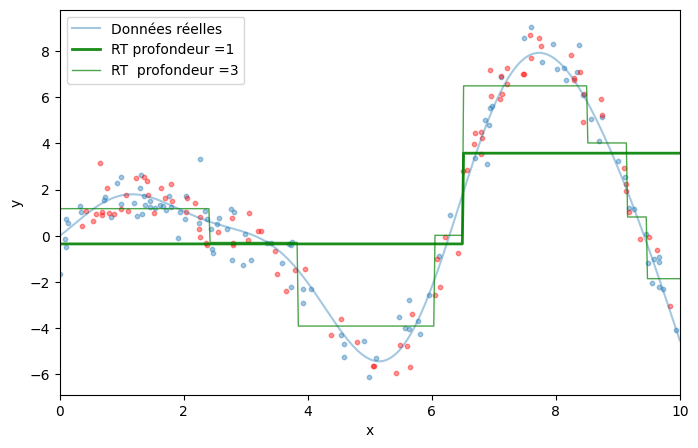

In [9]:
plot_data()
estim = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
plt.plot(x_plot, estim.predict(x_plot[:, np.newaxis]),
label='RT profondeur =1', color='g', alpha=0.9, linewidth=2)
estim = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
plt.plot(x_plot, estim.predict(x_plot[:, np.newaxis]),
label='RT  profondeur =3', color='g', alpha=0.7, linewidth=1)
plt.legend(loc='upper left')

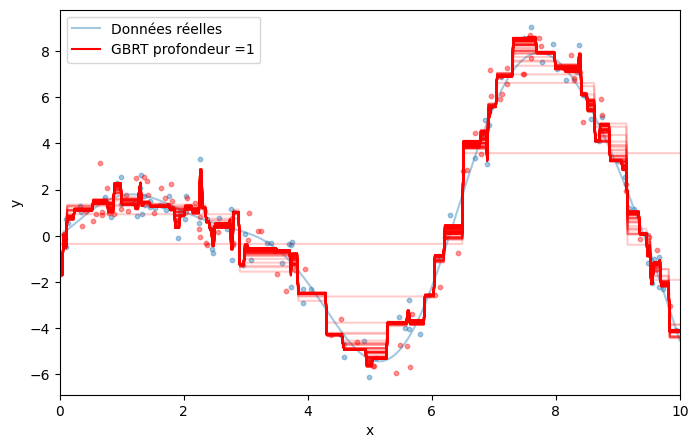

In [11]:
from itertools import islice
plot_data()
est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
est.fit(X_train, y_train)
ax = plt.gca()
first = True
# Affichage d'une ligne tous les 20 arbres.
for pred in islice(est.staged_predict(x_plot[:, np.newaxis]), 0, 1000, 10):
    plt.plot(x_plot, pred, color='r', alpha=0.2)
plt.plot(x_plot, pred, color='r', label='GBRT profondeur =1')
#connectionstyle="arc"))
plt.legend(loc='upper left')

Text(810, 0.25, 'écart test entrainement')

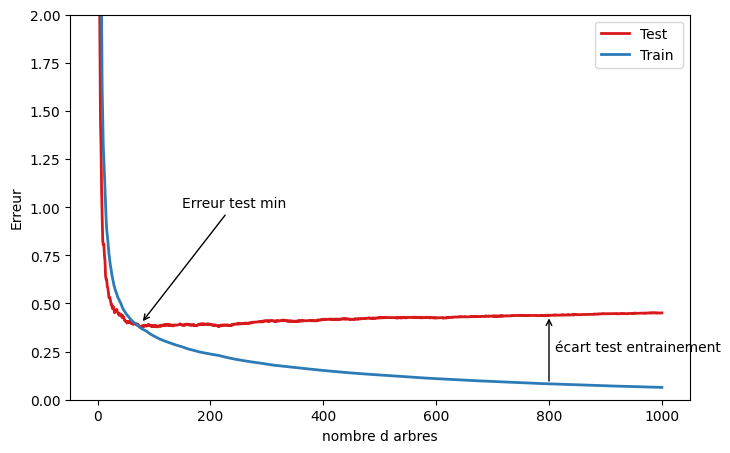

In [12]:
n_estimators = len(est.estimators_)

def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6',test_color='#d7191c', alpha=1.0):
  test_dev = np.empty(n_estimators)
  for i, pred in enumerate(est.staged_predict(X_test)):
    test_dev[i] = est._loss(y_test, pred)
  if ax is None:
    fig = plt.figure(figsize=(8, 5))
    ax = plt.gca()
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label,linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color,label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Erreur')
    ax.set_xlabel('nombre d arbres')
    ax.set_ylim((0, 2))
  return test_dev, ax

test_dev, ax = deviance_plot(est, X_test, y_test)
ax.legend(loc='upper right')
ax.annotate('Erreur test min', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02), xycoords='data',xytext=(150, 1.0), textcoords='data',arrowprops=dict(arrowstyle="->", connectionstyle="arc"))
ann = ax.annotate('', xy=(800, test_dev[799]), xycoords='data',xytext=(800, est.train_score_[799]), textcoords='data',arrowprops=dict(arrowstyle='->'))
ax.text(810, 0.25, 'écart test entrainement')

# **Partie 4 : Comparaison des algorithmes de Boosting.**

12° à 15°. Comparaison des 5 algorithmes de Boosting en termes de performances et de rapidité.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:25:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 345, number of negative: 355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4673
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492857 -> initscore=-0.028573
[LightGBM] [Info] Start training from score -0.028573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


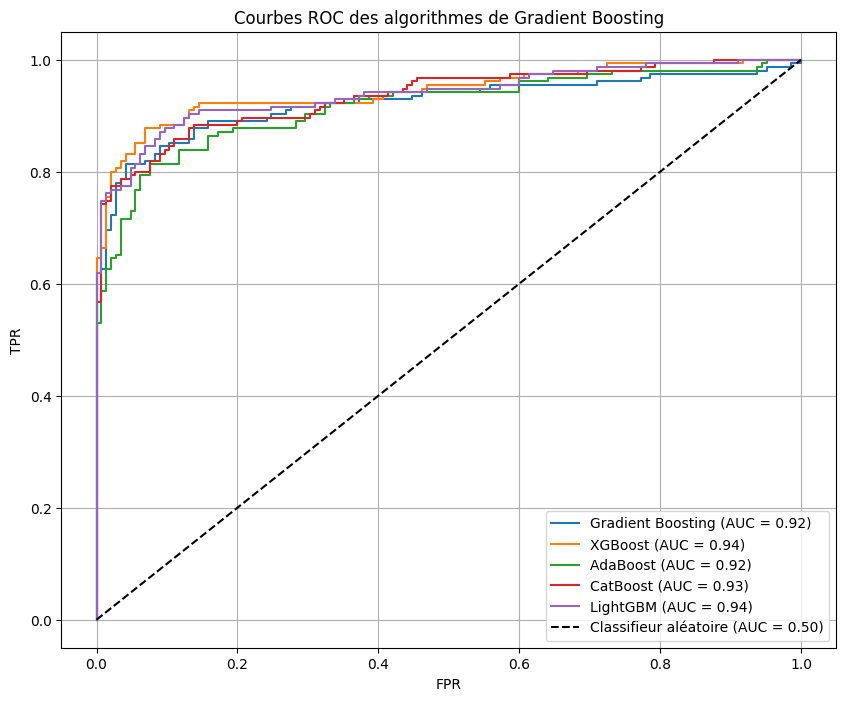

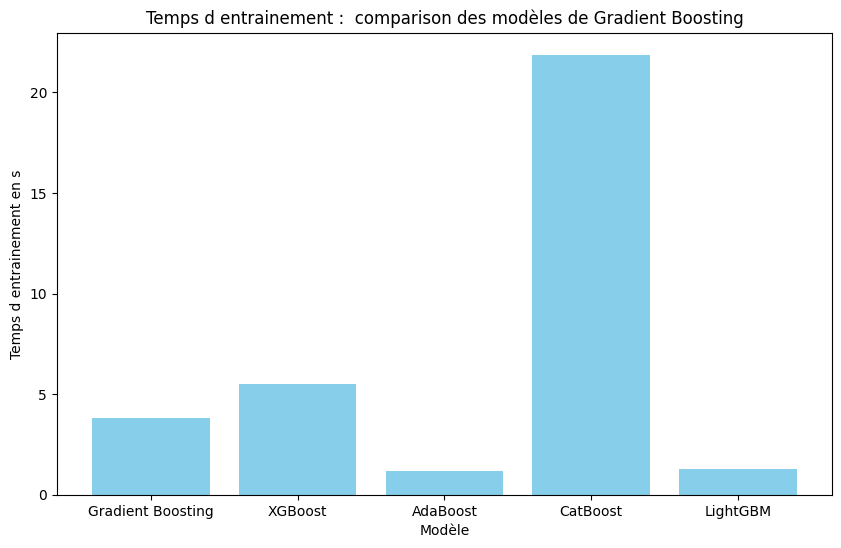

In [14]:
import time
train_times = {}
# Création d'un jeu de données synthétiques pour la classification binaire
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
classifiers = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'AdaBoost': AdaBoostClassifier(),
    'CatBoost': CatBoostClassifier(silent=True),
    'LightGBM': LGBMClassifier()
}
plt.figure(figsize=(10, 8))
for name, clf in classifiers.items():
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_times[name] = time.time() - start_time
    y_probs = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Classifieur aléatoire (AUC = 0.50)')
plt.title('Courbes ROC des algorithmes de Gradient Boosting')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
# Affichage du temps d'entrainement
plt.figure(figsize=(10, 6))
plt.bar(train_times.keys(), train_times.values(), color='skyblue')
plt.xlabel('Modèle')
plt.ylabel('Temps d entrainement en s')
plt.title('Temps d entrainement :  comparison des modèles de Gradient Boosting')
plt.show()

**Quelques remarques concernant Catboost.**

CatBoost (Categorical Boosting) est un algorithme de gradient boosting développé par Yandex, conçu pour :

- traiter automatiquement les variables catégorielles
- réduire le surapprentissage lié aux arbres symétriques
- accélérer l'apprentissage via des techniques d'optimisation

Propriété qui le distingue des autres techniques de Boosting : la gestion native des variables catégorielles; CatBoost convertit les catégories en ciblage (target encoding):

Pour chaque variable catégorielle $c$, CatBoost calcule :

$E(c)=\frac{\sum_{j<i}y_j1_{[c_j=c_i]}+\text{prior}}{\sum_{j<i}1_{[c_j=c_i]}+\text{coef}}$

Le modèle ne regarde jamais la cible du point $i$ avant de calculer son encodage $E$. On appelle cela l'OTS (Ordered Target Statistics)

- Autre caractéristique : CatBoost utilise des arbres symétriques : chaque niveau utilise la même règle de coupture pour tous les noeuds du niveau. La structure de l'arbre est très régulière. On parle d'"oblivious decision tree". Le calcul est très rapide, il y a moins de sur-apprentissage et c'est idéal pour un calcul sur GPU.

- Autre caractéristique : le boosting classique calcule les résidus sur toutes les données en utilisant le modèle entraîné jusque-là. CatBoost introduit  l'"Ordered Boosting". Le résidu pour un exemple $i$ est calculé avec un modèle qui n'a jamais vu cet exemple. Cela évite la "fuite de données", trop de variance ou du surajustement.

En conclusion, CatBoost,

- Nécessite peu de réglage d'hyperparamètres.
- Est robuste sur les jeux de données avec variables catégorielles.
- Est très performant même avec les petits jeux de données.
- Il est optimisé pour les calculs sur GPU.
- Mais il est plus lent sur les jeux de données numériques.


# **Partie 5 : retour sur le "California Housing Dataset".**

Etude de cas sur des données réelles : California Housing Dataset. Après avoir effectué une courte étude descriptive, on effectue une sélection de variables (comme pour une régression linéaire ou logistique) par la méthode RFE des modèles imbriqués. En ne conservant que les variables les plus significatives, on entraîne un modèle de gradient boosting (dont les classifieurs faibles sont des arbres) en sélectionnant, grâce à une validation croisée, les meilleurs paramètres.

Il faut se souvenir de l'étude faite sur ce jeu de données lors du TP2 : mauvais résultats en régression linéaire (problème sans doute pas linéaire car les prix varient fortement en fonction de la localisation et de façon non linéaire). Les distributions des variables en jeu ne sont pas gaussiennes.

16°. 17°. 18°.

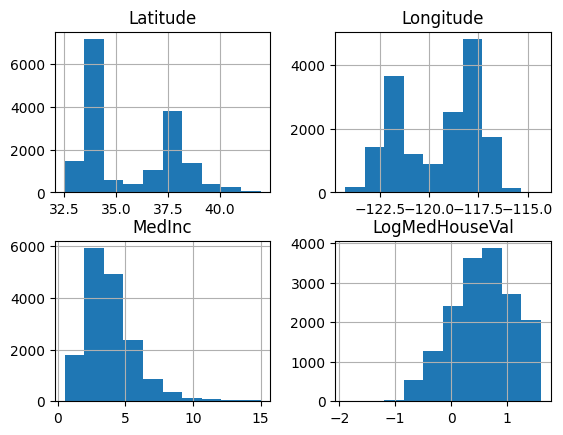

In [15]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
cal_housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,np.log(cal_housing.target),test_size=0.2,random_state=1)
names = cal_housing.feature_names
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['LogMedHouseVal'] = y_train
_ = X_df.hist(column=['Latitude', 'Longitude', 'MedInc', 'LogMedHouseVal'])

In [16]:
est = GradientBoostingRegressor(n_estimators=300, max_depth=2, learning_rate=0.04,loss='huber', random_state=0)
est.fit(X_train, y_train)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, est.predict(X_test))
print('MAE: %.4f' % mae)

MAE: 0.1965


19°.

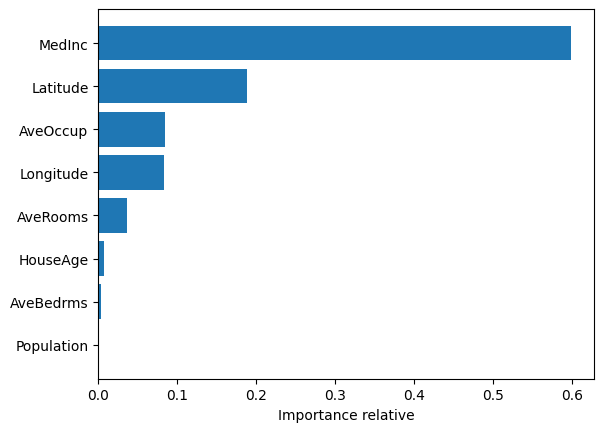

In [17]:
indices = np.argsort(est.feature_importances_)
plt.barh(np.arange(len(names)), est.feature_importances_[indices])
plt.yticks(np.arange(len(names)), [names[i] for i in indices])
_ = plt.xlabel('Importance relative')
plt.show()

20°. 21°.

In [23]:
from sklearn.preprocessing import StandardScaler
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
# Price = prix médian.
df['Price'] = housing.target
print(df.head())
# On va plutôt travailler avec le log des prix pour atténuer les valeurs extrêmes.
df['Price'] = np.log1p(df['Price'])
print(df.head())
# On normalise en plus les données (centrage et variance unité).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Price', axis=1))

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Price  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853  

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['Price'], test_size=0.2, random_state=42)

In [25]:
from sklearn.feature_selection import RFE
# RFE effectue une sélection itérative des variables (par modèles imbriqués).
# Nous avons déjà utilisé RFE lors du TP sur la régression logistique.
selector = RFE(est, n_features_to_select=5)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = df.drop('Price', axis=1).columns[selector.support_]
print(selected_features)

Index(['MedInc', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude'], dtype='object')


In [27]:
from sklearn.model_selection import GridSearchCV

#param_grid = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5]}
param_grid = {'n_estimators': [300], 'learning_rate': [0.1], 'max_depth': [5]}
# On sélectionne les meilleurs paramètres en utilisant GridSearch (très long)
grid_search = GridSearchCV(est, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_selected, y_train)
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


In [28]:
#BestLR=0.1
#BestDepth=5
#BestNbEstim=300
best_model = grid_search.best_estimator_
best_model.fit(X_train_selected, y_train)
X_test_selected = selector.transform(X_test)
y_pred = best_model.predict(X_test_selected)

In [29]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

mse_actual = mean_squared_error(y_test_exp, y_pred_exp)
r2 = r2_score(y_test_exp, y_pred_exp)
mae = mean_absolute_error(y_test_exp, y_pred_exp)
print("MSE:", mse_actual)
print("R^2:", r2)
print("MAE:", mae)

MSE: 0.22582784003178835
R^2: 0.8276661379907967
MAE: 0.3040398944431233


In [30]:
for i in range(5):
    print(f"Prix prédit: {y_pred_exp[i]:.2f}, prix réel: {y_test_exp.iloc[i]:.2f}")

Prix prédit: 0.51, prix réel: 0.48
Prix prédit: 0.67, prix réel: 0.46
Prix prédit: 5.02, prix réel: 5.00
Prix prédit: 2.35, prix réel: 2.19
Prix prédit: 2.37, prix réel: 2.78


Les résultats sont nettement meilleurs qu'avec les modèles du TP2.

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['Price'] = housing.target
print("Résumé du jeu de données:")
print(df.head())
# On travaillera avec le logarithme du prix médian.
df['Price'] = np.log1p(df['Price'])
print("\nDonnées après transformation log :")
print(df.head())
# Normalisation des données.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Price', axis=1))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['Price'], test_size=0.2, random_state=42)
model = GradientBoostingRegressor()
selector = RFE(model, n_features_to_select=5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_features = df.drop('Price', axis=1).columns[selector.support_]
print("\nVariables sélestionnées:", selected_features)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
best_model = grid_search.best_estimator_
print("\nMeilleurs paramètres trouvés par GridSearchCV:", grid_search.best_params_)
best_model.fit(X_train_selected, y_train)
y_pred = best_model.predict(X_test_selected)
mse_log_transformed = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
print("\nMSE à partir du prix initial:", mse_log_transformed)
# Validation croisée
mse_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error')
mse_mean = -mse_scores.mean()
print("\nValidation croisée MSE:", mse_mean)
y_pred_exp = np.expm1(y_pred)
y_test_exp = np.expm1(y_test)
mse_actual = mean_squared_error(y_test_exp, y_pred_exp)
print("\nMSE sur les données initiales:", mse_actual)
r2 = r2_score(y_test_exp, y_pred_exp)
print("R^2:", r2)
mae = mean_absolute_error(y_test_exp, y_pred_exp)
print("MAE:", mae)
print("\nExemple de prédiction:")
for i in range(5):
    print(f"Predit: {y_pred_exp[i]:.2f}, Prix réel: {y_test_exp.iloc[i]:.2f}")
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = 1.5 * IQR
outliers = df[(df['Price'] < (Q1 - outlier_threshold)) | (df['Price'] > (Q3 + outlier_threshold))]
print(f"\nNombre de données aberrantes: {len(outliers)}")
df_filtered = df[~((df['Price'] < (Q1 - outlier_threshold)) | (df['Price'] > (Q3 + outlier_threshold)))]

Résumé du jeu de données:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Price  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  

Données après transformation log :
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059     

Bagging.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,n_informative=2, n_redundant=0,random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
print(clf.predict([[0, 0, 0, 0]]))

[1]


In [33]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, confusion_matrix,ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score, ShuffleSplit,RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

In [34]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
labels *=100
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

In [35]:
def train_regressor(estimator, X_train, y_train, cv, name):
    cv_results = cross_validate(estimator,X_train,y_train,cv=cv,scoring="neg_mean_absolute_error",return_train_score=True,return_estimator=True)
    cv_train_error = -1 * cv_results['train_score']
    cv_test_error = -1 * cv_results['test_score']
    print(f"En moyenne, {name} fait une erreur de "f"{cv_train_error.mean():.3f}k +/- {cv_train_error.std():.3f}k sur le jeu d'entrainement.")
    print(f"En moyenne, {name} fait une erreur de "f"{cv_test_error.mean():.3f}k +/- {cv_test_error.std():.3f}k sur le jeu de test.")

In [37]:
train_regressor(DecisionTreeRegressor(), com_train_features,com_train_labels, cv, 'decision tree regressor')
train_regressor(BaggingRegressor(), com_train_features,com_train_labels, cv, 'bagging regressor')
train_regressor(RandomForestRegressor(), com_train_features,com_train_labels, cv, 'random forest regressor')

En moyenne, decision tree regressor fait une erreur de 0.000k +/- 0.000k sur le jeu d'entrainement.
En moyenne, decision tree regressor fait une erreur de 47.262k +/- 1.270k sur le jeu de test.
En moyenne, bagging regressor fait une erreur de 14.463k +/- 0.112k sur le jeu d'entrainement.
En moyenne, bagging regressor fait une erreur de 35.252k +/- 0.942k sur le jeu de test.
En moyenne, random forest regressor fait une erreur de 12.642k +/- 0.076k sur le jeu d'entrainement.
En moyenne, random forest regressor fait une erreur de 33.326k +/- 0.699k sur le jeu de test.


Analyse des résultats :

- Decision Tree Regressor : ce modèle surapprend totalement les données d'entraînement, avec une erreur nulle. Il ne généralise pas bien et produit des erreurs élevées sur le jeu de test, ce qui est typique d'une situation de sur-apprentissage.

- Bagging Regressor : contrairement à l'arbre de décision, le bagging regressor ne sur-apprend pas aussi fortement. L'erreur sur le jeu de test est significativement plus faible que celle de l'arbre de décision, indiquant une meilleure généralisation.

- Random Forest Regressor : l'erreur d'entraînement est plus élevée que celle de l'arbre de décision, ce qui est normal. Le Random Forest est conçu pour être plus robuste et éviter le sur-apprentissage, en combinant plusieurs arbres de décision. L'erreur nulle comme celle de l'arbre de décision ne se produit pas ici. L'erreur sur le jeu de test est légèrement plus faible que celle du bagging regressor, ce qui suggère que le Random Forest réussit à mieux généraliser que le Bagging, malgré une erreur d'entraînement un peu plus élevée. Le Random Forest parvient à équilibrer le biais et la variance.

Le Random Forest Regressor semble être le meilleur modèle en termes de généralisation. Bien qu'il ait une erreur d'entraînement plus élevée que celle du bagging regressor, il donne une erreur de test plus faible, ce qui montre qu'il est plus robuste et a trouvé un bon compromis entre biais et variance.

Comparons les résultats obtenus ci-dessus avec ceux de la littérature (California Housing Dataset étant un benchmark très courant) :

On constate des résultats similaires pour les trois modèles testés : Decision Trees, Random Forests, et Bagging Regressors.

- Arbre de décision : sur-apprentissage. Sur le jeu de données California Housing, un arbre non régularisé affiche bien une très faible erreur d'entraînement mais une grande erreur de test. Résultats typiques : Des erreurs de test entre 40k et 60k sont observées, ce qui correspond bien àà nos résultats.

- Bagging Regressor : le Bagging réduit le sur-apprentissage en combinant plusieurs arbres de décision pour diminuer la variance. Dans la littérature, on trouve que les erreurs sur le jeu de test pour le Bagging Regressor (sur ce jeu de données) sont autour de 30k-40k, ce qui correspond bien à nos résultats. Le Bagging Regressor est souvent plus stable et moins sensible aux fluctuations des données que l'arbre de décision de base, ce qui est confirmé par tes résultats.

- Random Forest Regressor : Random Forest est une extension du bagging qui, en plus de réduire la variance, améliore la performance en introduisant une randomisation supplémentaire (en sélectionnant aléatoirement un sous-ensemble de caractéristiques pour chaque arbre). Sur ce jeu de données, il est courant d'obtenir des erreurs de test proches de 30k, avec des performances légèrement meilleures que celles du Bagging. Dans la littérature, le Random Forest sur le California Housing Dataset peut donner des erreurs de dont l'ordre de grandeur est dans l'intervall 25k-35k, ce qui correspond au niveau d'erreur que nous avons trouvés.


Nos résultats sont parfaitement cohérents avec ce qu'on trouve dans la littérature sur le California Housing Dataset.


In [38]:
param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
}
search_cv = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=2), param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=10, random_state=0, n_jobs=2,)
search_cv.fit(com_train_features, com_train_labels)
columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

param_n_estimators  param_max_leaf_nodes  mean_test_error  std_test_error
0                 500                   100        40.634069        0.693362
2                  10                   100        41.419497        1.052692
7                 100                    50        43.854123        0.843959
8                   1                   100        45.822411        0.867044
6                  50                    20        49.428207        1.262728
1                 100                    20        49.451606        1.144040
9                  10                    20        50.266898        1.431076
3                 500                    10        55.029594        1.025058
4                   5                     5        61.582537        1.051312
5                   5                     2        73.213880        1.002747

In [39]:
error = -search_cv.score(test_features, test_labels)
print(f"En moyenne, le régresseur Random Forest fait une erreur de {error:.2f} k$")

En moyenne, le régresseur Random Forest fait une erreur de 40.41 k$


# **Partie 6 : Stacking**

24°. 25°. 26°. 27°.

In [40]:
from sklearn import datasets
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
import numpy as np
import warnings
warnings.simplefilter('ignore')
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],meta_classifier=lr)
print('3-fold cross validation:\n')
for clf, label in zip([clf1, clf2, clf3, sclf],
                      ['KNN',
                       'Random Forest',
                       'Naive Bayes',
                       'StackingClassifier']):
    scores = model_selection.cross_val_score(clf, X, y,
                                              cv=3, scoring='accuracy')
    print("Performances (Accuracy): %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Performances (Accuracy): 0.91 (+/- 0.01) [KNN]
Performances (Accuracy): 0.95 (+/- 0.01) [Random Forest]
Performances (Accuracy): 0.91 (+/- 0.02) [Naive Bayes]
Performances (Accuracy): 0.00 (+/- 0.00) [StackingClassifier]


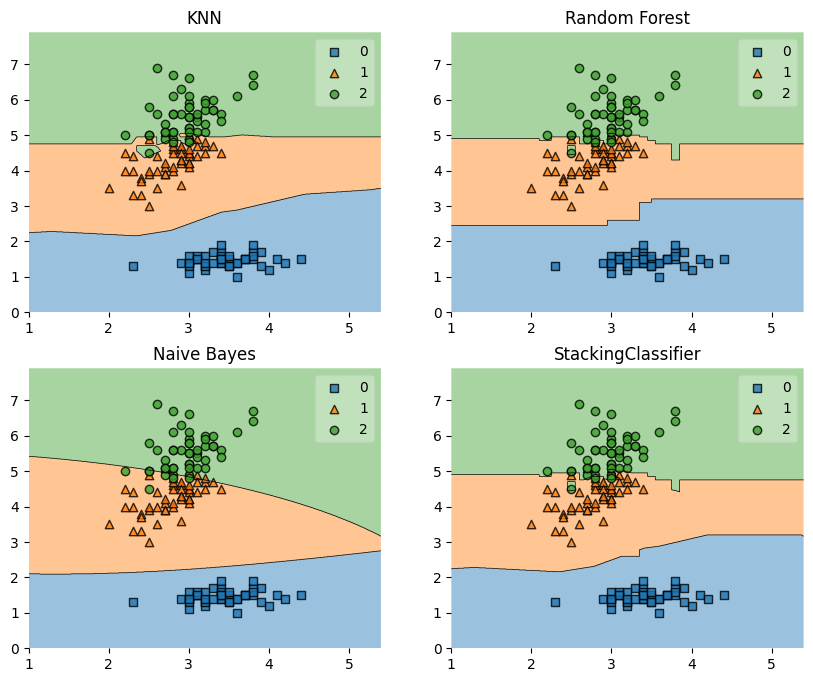

In [41]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for clf, lab, grd in zip([clf1, clf2, clf3, sclf],
                         ['KNN',
                          'Random Forest',
                          'Naive Bayes',
                          'StackingClassifier'],
                          itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)

In [42]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

print('Validation croisée 3-fold:\n')

for clf, label in zip([clf1, clf2, clf3, sclf],
                      ['KNN',
                       'Random Forest',
                       'Naive Bayes',
                       'StackingClassifier']):
    scores = model_selection.cross_val_score(clf, X, y,cv=3, scoring='accuracy')
    print("Performances (Accuracy): %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

Validation croisée 3-fold:

Performances (Accuracy): 0.91 (+/- 0.01) [KNN]
Performances (Accuracy): 0.95 (+/- 0.01) [Random Forest]
Performances (Accuracy): 0.91 (+/- 0.02) [Naive Bayes]
Performances (Accuracy): 0.00 (+/- 0.00) [StackingClassifier]


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier

# Initialisation des modèles
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          meta_classifier=lr)

# Recherche des meilleurs paramètres.
params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}
grid = GridSearchCV(estimator=sclf,param_grid=params,cv=5, refit=True)
grid.fit(X, y)
cv_keys = ('mean_test_score', 'std_test_score', 'params')
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

# Résultats.
print('Meilleurs paramètres: %s' % grid.best_params_)
print('Performances (Accuracy): %.2f' % grid.best_score_)

0.847 +/- 0.08 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.853 +/- 0.08 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.887 +/- 0.06 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.913 +/- 0.04 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.853 +/- 0.07 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.867 +/- 0.06 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.893 +/- 0.05 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.920 +/- 0.04 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_